In [1]:
import matplotlib.pyplot as plt
import random
import sys
import mmh3
import numpy as np
import pandas as pd
import scipy.stats
import ipywidgets as widgets

from multiprocessing import Process
from copy import copy
from datasketches import KllFloatSketch
from collections import deque
from enum import Enum
from ipywidgets import HBox, VBox
from IPython.display import display

%matplotlib inline

In [2]:
class Status(Enum):
    GREEN = 1
    YELLOW = 2
    RED = 3

In [3]:
class Worker:
    def __init__(self, worker_id, sketch_k=4000):
        self.id = worker_id
        self.sketch_k = sketch_k
        self.reset_sketch()
        self.trash = None
        self.ks_p_values = []
        self.status = Status.GREEN
        self.counter = 0
    
    def push(self, value, repeat_test=1, test=True):
        self.counter += 1
        self.sketch.update(value)
        if test and self.counter % repeat_test == 0:
            self.test()
        return self.status
    
    def reset_sketch(self):
        self.sketch = KllFloatSketch(self.sketch_k)
    
    def reset_trash(self):
        self.trash = self.counter + 1
    
    def sketch_values(self):
        m = self.sketch.getNumRetained()
        values = self.sketch.getQuantiles(list(np.arange(m) / m))
        return values
    
    def sketch_mean(self):
        return np.mean(self.sketch_values())

    def sketch_std(self):
        return np.std(self.sketch_values())

    def test(self, alpha=0.05):
        m = self.sketch.getNumRetained()
        values = self.sketch.getQuantiles(list(np.arange(m) / m))

        mu = np.mean(values)
        std = np.std(values)
        
        values = values - self.sketch_mean()
        values = values / self.sketch_std()
        _, ks_p_value = scipy.stats.kstest(values, 'norm')
        
        self.status = Status.GREEN
        self.ks_p_values.append(ks_p_value)

        if ks_p_value < alpha:
            self.status = Status.RED

In [4]:
class StreamProcessor:
    def __init__(self, n_workers=1, k=4000):
        self.n_workers = n_workers
        self.workers = \
            [Worker(i, sketch_k=k) for i in range(n_workers)]
        self.single_detection = False
        self.single_detection_time = None
        self.majority_detection_time = None
        self.all_detection_time = None
        self.majority_detection = False
        self.all_detection = False
        self.status = {i : self.workers[i].status for i in range(n_workers)}
        self.counter = 0

    def push(self, ids, values, test=True, hash_type='id', repeat_test=1, verbose=True, ret='votes'):
        if test:
            self.trash = self.counter + 1
        
        assert len(ids) == len(values)
        self.repeat_test = repeat_test
        
        sum_history = []
        single_vote = 0
        majority_vote = 0
        all_vote = 0
        vote_sum = 0
        
        for i in range(len(values)):            
            if hash_type == 'roundrobin':
                ind = self.counter % self.n_workers
            else:
                if hash_type == 'id':
                    hash_key = str(ids[i])
                else:
                    hash_key = str(values[i])
                ind = mmh3.hash(hash_key + 'qwe') % self.n_workers
            self.counter += 1
            
            st = self.workers[ind].push(values[i], repeat_test=repeat_test, test=test)
            
            if st == Status.RED:
                self.status[ind] = st
            
            if test:
                vote_sum = sum(1 for i, v in self.status.items() if v == Status.RED)
                
                if vote_sum >= 1 and single_vote == 0:
                    single_vote = self.counter - self.trash
                if vote_sum > self.n_workers // 2 and majority_vote == 0:
                    majority_vote = self.counter - self.trash
                if vote_sum == self.n_workers and all_vote == 0:
                    all_vote = self.counter - self.trash
                    break
                
                if ret == 'sum' and self.counter % repeat_test == 0:
                    sum_history.append(vote_sum)
        if ret == 'votes':
            return single_vote, majority_vote, all_vote
        return sum_history
    
    def update_status(self, verbose=False):
        st = self.workers_status()
        if self.single_detection is False:
            if (st.count(Status.RED)) >= 1:
                self.single_detection = True
                self.single_detection_time = self.counter
                if verbose:
                    print(f"single detection at step {self.counter}")
        if self.majority_detection is False:
            if (st.count(Status.RED)) > self.n_workers // 2:
                self.majority_detection = True
                self.majority_detection_time = self.counter
                if verbose:
                    print(f"majority detection at step {self.counter}")
        if self.all_detection is False:
            if (st.count(Status.RED)) == self.n_workers:
                self.all_detection = True
                self.all_detection_time = self.counter
                if verbose:
                    print(f"all detection at step {self.counter}")
    
    def reset_sketches(self):
        for w in self.workers:
            w.reset_sketch()

    def set_trash_count(self, cnt=-1):
        if cnt == -1:
            self.trash = self.counter + 1
        else:
            self.trash = cnt

    def reset_p_values(self):
        for w in self.workers:
            w.reset_p_values()
            
    def workers_status(self):
        return [w.status for w in self.workers]
    
    def plot_p_values(self, grid_size=100):
        plt.figure(figsize=(16, 4 * self.n_workers))
        gs = plt.GridSpec(self.n_workers, 1)

        for i in range(self.n_workers):
            ks_p_values = self.workers[i].ks_p_values
            x = np.array(range(0, len(ks_p_values) * self.repeat_test, self.repeat_test))
            
            plt.subplot(gs[i,0])
            plt.plot(x, ks_p_values, 'r', label='kolmogorov-smirnov')
            plt.legend(loc='upper left')
            plt.axhline(0.05)
            if self.workers[i].trash is not None:
                plt.axvline(self.workers[i].trash // self.repeat_test)
            plt.subplots_adjust(hspace=0.4)
            plt.title(f"{i}-th worker")
            plt.ylabel('p-value')
        plt.tight_layout()
        plt.show()
    

In [5]:
def generate_params_from_id(uid):
    mu = uid * 1
    sigma = 1
    return mu, sigma


def gererate_uniform_data(a=0, b=1, size=10000):
    values = np.random.uniform(a, b, size)
    ids = np.random.randint(0, size // 10, size)
    return ids, values


def gererate_normal_data(mu=0, sigma=1, size=10000):
    values = np.random.normal(mu, sigma, size)
    ids = np.random.randint(0, size // 10, size)
    return ids, values


def gererate_trash_from_ids(cond, mu=0, sigma=1, size=10000):
    values = np.zeros(size)
    ids = np.zeros(size)
    for i in range(size):
        uid = random.randint(0, 32)
        ids[i] = uid
        values[i] = random.gauss(10, 2) if cond(uid) else random.gauss(mu, sigma)
    return ids, values


def get_height_data():
    url = 'http://socr.ucla.edu/docs/resources/SOCR_Data/SOCR_Data_Dinov_020108_HeightsWeights.html'
    df = pd.read_html(url)[0][1:]
    return np.array(df[0], dtype='int'), np.array(df[1], dtype='float64')


# procs = []
# norm_ids, norm_values = gererate_normal_data(0, 1, 1000)

# @widgets.interact_manual(
#     n_workers=[1, 2, 4, 8, 16],
#     hash_by_id=[True, False],
#     test_values=['norm', 'uni'],
#     a=list(range(-100, 100)),
#     b=list(range(100)),
#     size=[i for i in range(50, 15000, 50)]
# )
# def test(n_workers=1, hash_by_id=True, test_values='norm', a=0, b=1, size=500):
#     proc = StreamProcessor(n_workers=n_workers)
#     proc.push(norm_ids, norm_values, test=False)
#     proc.set_trash_count()
#     ids, vals = generator(a, b, test_values, size)
#     proc.push(ids, vals)
#     show_info(proc)
#     proc.plot_p_values()
# #     print(f"workers: {n_workers}, hash by id: {hash_by_id}, size")

# def gererate_users_weight_data(users, size):
#     i = random.randint(0, len(users))
#     values = np.zeros(size)
#     ids = np.zeros(size)
#     for i in range(size):
#         ids[i] = uid
#         mu, std = users_id[uid]
#         values[i] = random.gauss(mu, std)
#     return ids, values

In [6]:
ids, height = get_height_data()
np.random.shuffle(height)
a = height.min()
b = height.max()

In [ ]:
n_test = 1
max_n_shards = 16

fvs = []
mvs = []
avs = []

for i in range(1, max_n_shards + 1):
    fv_mean = 0
    mv_mean = 0
    av_mean = 0
    for j in range(n_test):
        proc = StreamProcessor(n_workers=i)
        proc.push(ids[:i * 1000], height[:i * 1000], test=False)
        uni_ids, vals = gererate_uniform_data(a, b, size=i * 1000)
        fv, mv, av = proc.push(uni_ids, vals, test=True, repeat_test=10)
        fv_mean += fv
        mv_mean += mv
        av_mean += av
    fv_mean /= i
    mv_mean /= i
    av_mean /= i
    
    fvs.append(fv_mean)
    mvs.append(mv_mean)
    avs.append(av_mean)
    print(f"n = {i}, fv = {fv_mean:.2f}, mv = {mv_mean:.2f}, av = {av_mean:.2f}")

n = 1, fv = 159.00, mv = 159.00, av = 159.00
n = 2, fv = 75.50, mv = 503.50, av = 503.50
n = 3, fv = 51.00, mv = 285.33, av = 333.00
n = 4, fv = 122.50, mv = 146.50, av = 176.75
n = 5, fv = 120.60, mv = 140.20, av = 229.40
n = 6, fv = 87.83, mv = 207.00, av = 316.50
n = 7, fv = 108.29, mv = 175.57, av = 0.00
n = 8, fv = 61.75, mv = 166.50, av = 0.00
n = 9, fv = 95.89, mv = 253.11, av = 624.56
n = 10, fv = 91.50, mv = 229.80, av = 640.80
n = 11, fv = 88.36, mv = 246.36, av = 0.00
n = 12, fv = 103.92, mv = 308.83, av = 0.00
n = 13, fv = 45.31, mv = 215.31, av = 0.00
n = 14, fv = 136.00, mv = 281.29, av = 0.00


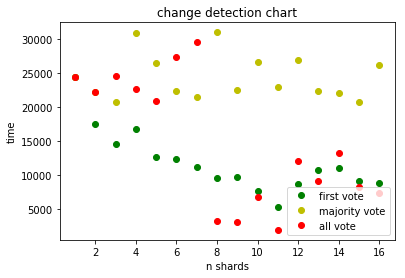

In [18]:
x = np.arange(1, max_n_shards + 1)
plt.plot(x, fvs, 'go', label='first vote')
plt.plot(x, mvs, 'yo', label='majority vote')
plt.plot(x, avs, 'ro', label='all vote')
plt.title('change detection chart')
plt.ylabel('time')
plt.xlabel('n shards')
plt.legend(loc='lower right')

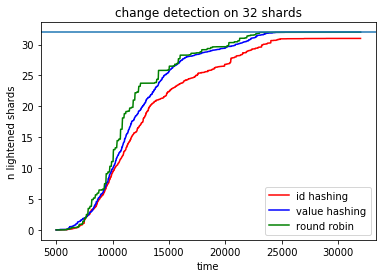

In [25]:
n = 32
n_test = 10
repeat=10
size = 500

norm_ids, norm_vals = gererate_normal_data(100, 10, n * size)
uni_ids, vals = gererate_uniform_data(a-5, b+5, size=n * size)

common_d_by_id = np.zeros(n * size // repeat)
common_d_by_value = np.zeros(n * size // repeat)
common_d_robin = np.zeros(n * size // repeat)

for i in range(n_test):
    proc = StreamProcessor(n_workers=n, k=64)
    proc.push(norm_ids, norm_vals, hash_type='id', test=False)
    d = proc.push(uni_ids, vals, test=True, hash_type='id', repeat_test=repeat, ret='sum')
    common_d_by_id += d
    print(f'test {i}')

for i in range(n_test):
    proc = StreamProcessor(n_workers=n, k=64)
    proc.push(norm_ids, norm_vals, hash_type='value', test=False)
    d = proc.push(uni_ids, vals, test=True, hash_type='value', repeat_test=repeat, ret='sum')
    common_d_by_value += d
    print(f'test {i}')

for i in range(n_test):
    proc = StreamProcessor(n_workers=n, k=64)
    proc.push(norm_ids, norm_vals, hash_type='roundrobin', test=False)
    d = proc.push(uni_ids, vals, test=True, hash_type='roundrobin', repeat_test=repeat, ret='sum')
    common_d_robin += d
    print(f'test {i}')

common_d_by_id /= n_test
common_d_by_value /= n_test
common_d_robin /= n_test

# np.save('by_value3', np.array(common_d_by_value))
# np.save('by_id3', np.array(common_d_by_id))
# np.save('robin3', np.array(common_d_robin))

x = np.arange(0, len(common_d_by_id) * repeat, repeat)
# plt.figure(figsize=(16, 10))
fr = 1000
to = len(common_d_by_id) // 2

plt.plot(x[fr:to], common_d_by_id[fr:to], 'r', label='id hashing')
plt.plot(x[fr:to], common_d_by_value[fr:to], 'b', label='value hashing')
plt.plot(x[fr:to], common_d_robin[fr:to], 'g', label='round robin')
plt.title('change detection on 32 shards')
plt.ylabel('n lightened shards')
plt.xlabel('time')
plt.axhline(n)
plt.legend(loc='lower right')

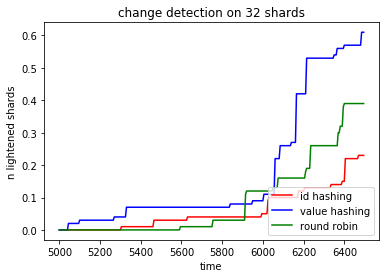

In [28]:
fr = 1000
to = 1300

plt.plot(x[fr:to], common_d_by_id[fr:to], 'r', label='id hashing')
plt.plot(x[fr:to], common_d_by_value[fr:to], 'b', label='value hashing')
plt.plot(x[fr:to], common_d_robin[fr:to], 'g', label='round robin')
plt.title('change detection on 32 shards')
plt.ylabel('n lightened shards')
plt.xlabel('time')
# plt.axhline(n)
plt.legend(loc='lower right')

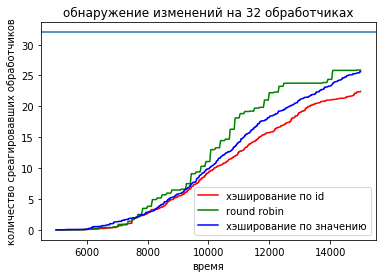

In [29]:
n = 32
common_d_by_id = np.load('by_id2.npy')
common_d_by_value = np.load('by_value2.npy')
common_d_robin = np.load('robin2.npy')
repeat = 5
x = np.arange(0, len(common_d_by_id) * repeat, repeat)
# plt.figure(figsize=(16, 10))
to = 3000
fr = 1000
plt.plot(x[fr:to], common_d_by_id[fr:to], 'r', label='хэширование по id')
plt.plot(x[fr:to], common_d_robin[fr:to], 'g', label='round robin')
plt.plot(x[fr:to], common_d_by_value[fr:to], 'b', label='хэширование по значению')
plt.title('обнаружение изменений на 32 обработчиках')
plt.ylabel('количество среагировавших обработчиков')
plt.xlabel('время')
plt.axhline(n)
plt.legend(loc='lower right')

In [ ]:
# proc = StreamProcessor(n_workers=n)
# proc.push(ids, height, hash_by_id=False, test=False)
# d = proc.push(uni_ids, vals, hash_by_id=False, test=True, repeat_test=repeat)
# x = np.arange(0, len(d) * repeat, repeat)
# plt.plot(x, d)
# plt.axhline(n)

In [ ]:
# def test(n=1, n_tests=1, size=1000, test_size=1000, hash_by_id=False):
#     detection_times = []
#     for i in range(n_tests):
#         proc = StreamProcessor(n_workers=n)
#         proc.push(ids[:size], height[:size], test=False, hash_by_id=hash_by_id)
        
#         uni_ids, vals = gererate_uni_data(a, b, size=test_size)
#         time = proc.push1(uni_ids, vals, test=True, repeat_test=20, hash_by_id=hash_by_id)
#         detection_times.append(time)
#     mean = np.mean([t for t in detection_times if t is not None])
#     none_prop = detection_times.count(None) / len(detection_times)
#     print(f"test for {n} workers finished, mean: {mean}")
# #     with open(f'experiments/{n}_workers.txt', 'w') as f:
# #         f.write(f"{mean}, {none_prop}")
#     return mean, none_prop

In [ ]:
# for n in n_workers:
#     detections.append(test(n=n, n_tests=50, size=n * 1000, test_size=n * 1000, hash_by_id=True))

In [ ]:
# def gererate_users_weight_data(users, size):
#     i = random.randint(0, len(users))
#     values = np.zeros(size)
#     ids = np.zeros(size)
#     for i in range(size):
#         ids[i] = i
#         mu, std = users[i]
#         values[i] = random.gauss(mu, std)
#     return ids, values

# size = 10000
# ids, values = gererate_users_weight_data(users_id, size)
# new_ids, new_values = gererate_users_weight_data(users_id, 1000)

# data_min = np.min(values)
# data_max = np.max(values)

In [ ]:
# dots = [(i, v[0]) for i, v in enumerate(detections, start=1) if v[1] != 1]
# x = [i[0] for i in dots]
# y = [i[1] for i in dots]
# plt.plot(x, y)
# plt.xlabel('n workers')
# plt.ylabel('mean time of first change detection')

In [ ]:
# n_detections = []
# for n in n_workers:
#     n_detections.append(test(n=n, n_tests=50, size=n * 10000, test_size=n * 1000, hash_by_id=True))

In [ ]:
# processes = [
#     Process(target=test(n=n, n_tests=100, size=10000, test_size=2000, hash_by_id=True)) for n in n_workers
# ]
# for p in processes:
#     p.start()
# for p in processes:
#     p.join()